# Luzon Monthly Peak Electricity Demand 2008-2022

This notebook contains time series analysis and forecasting of the Luzon monthly peak electricity demand from years 2008-2022. This means that we have a total of 15 years of monthly data in our hand. <br>

After performing some analysis on the time series we are going to try forecasting by primarily using ARIMA models and adding external regressors as we see fit.
  
<br>
The data from this notebook can be obtained from the NGCP website. 
<br>
https://www.ngcp.ph/operations#operations

In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from pathlib import os

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (11, 4)
plt.rcParams["font.size"] = 12


In [14]:
file = "Luzon_monthly_peak.csv"
path = os.path.join(os.path.realpath(".."), "datasets", file)

ts = pd.read_csv(path, dtype="float")["mw_peak"]
dates = pd.date_range("2008-01-01", "2022-12-01", freq="MS")
ts.index = dates
ts

2008-01-01     5972.0
2008-02-01     6094.0
2008-03-01     6211.0
2008-04-01     6663.0
2008-05-01     6485.0
               ...   
2022-08-01    11277.0
2022-09-01    11469.0
2022-10-01    11282.0
2022-11-01    10989.0
2022-12-01    10844.0
Freq: MS, Name: mw_peak, Length: 180, dtype: float64

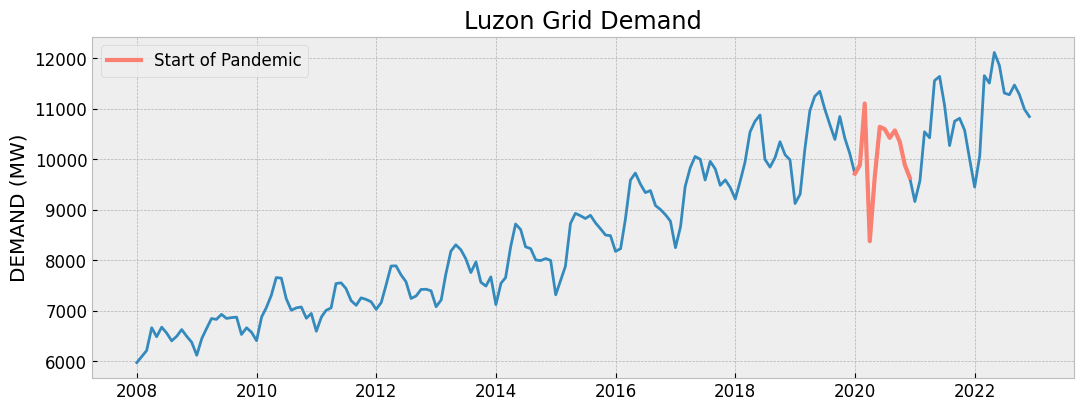

In [32]:
plt.plot(ts)
plt.plot(ts[ts.index.year == 2020], label="Start of Pandemic", color="salmon", linewidth=3)

ax = plt. gca()
ax.set_ylabel("DEMAND (MW)")
plt.legend()
plt.tight_layout()
plt.title("Luzon Grid Demand")
plt.show()

We see that the trend is roughly linear and we see that the seasonal variation over time increases, we need to take into account these two factors when we start building our models <br>
A glaring problem in the time series is seen in the year 2020, where the start of the pandemic began. We see a drastic drop in demand and its shape is uncomparable to nearby years. We have to perform some processing so that this outlier event does not significantly harm the perfomance of our models later.

Text(0.5, 1.0, 'Regression Plot')

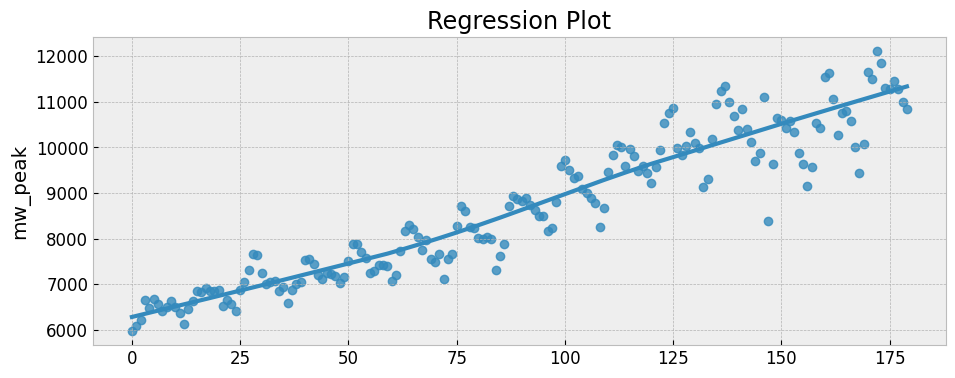

In [105]:
sns.regplot(x=np.arange(len(ts)), y=ts, lowess=True)
plt.title("Regression Plot")

We can see that the trend of the time series is almost linear.

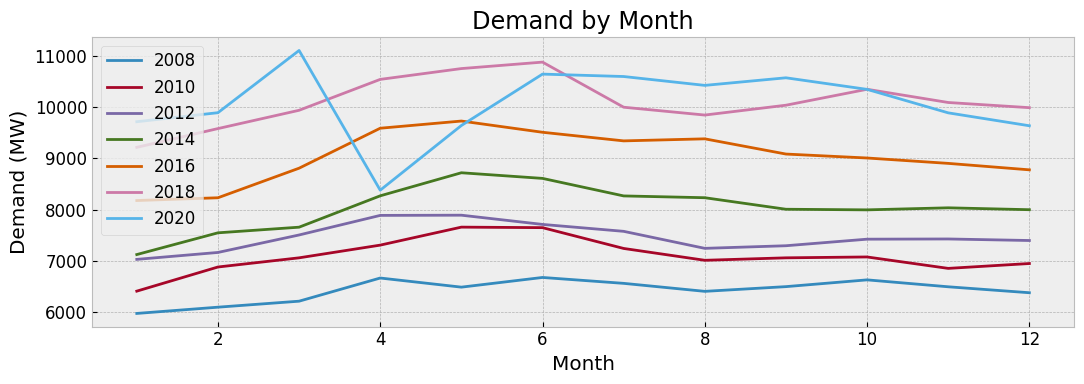

In [33]:
for year in range(2008, 2022, 2):
    sns.lineplot(x=ts_train[ts_train.index.year == year].index.month, y=ts_train[ts_train.index.year == year], label=year)
    
plt.ylabel("Demand (MW)")
plt.xlabel("Month")
plt.legend()
plt.title("Demand by Month")
plt.tight_layout()

We see that the peak of the year generally occurs between the 4th and 6th month. We also see an outlier behavior in the year 2020.

In [4]:
from sklearn.metrics import mean_absolute_percentage_error as mape

ts_train = ts.iloc[:-12]
ts_test = ts.iloc[-12:]

In [12]:
def plot_fore(train, test=None, forecast=None, inv_log=False):
    if inv_log:
        train = np.e ** train
        test = np.e ** test
        forecast = np.e ** forecast
        
    plt.plot(train)
    if test is not None:
        plt.plot(test, label="Actual")
    if forecast is not None:
        plt.plot(forecast, label="Forecast")
    plt.legend()
    

Text(0.5, 1.0, 'Variance Per Year')

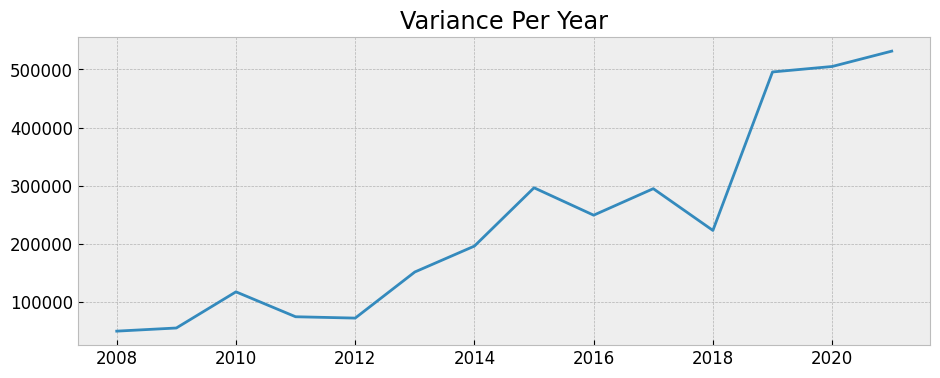

In [34]:
ts_train.groupby(ts_train.index.year).var().plot()
plt.title("Variance Per Year")

We see an increase in variance per year, lets take the log transform in order to reduce it.

<AxesSubplot: title={'center': 'Time Series With Log Transform'}>

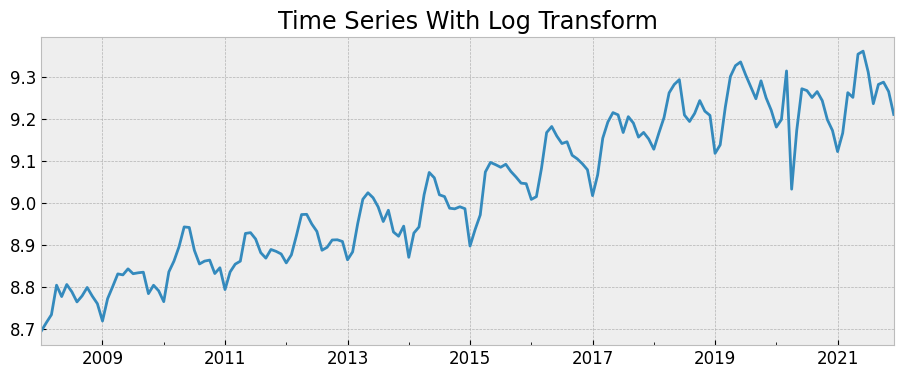

In [40]:
# Perform log transform
ts_train_log = np.log(ts_train)
ts_test_log = np.log(ts_test)
plt.title("Time Series With Log Transform")
ts_train_log.plot()

We see that after the log transformation, we've somewhat reduced the variance over time.

Text(0.5, 1.0, 'Variance Per Year')

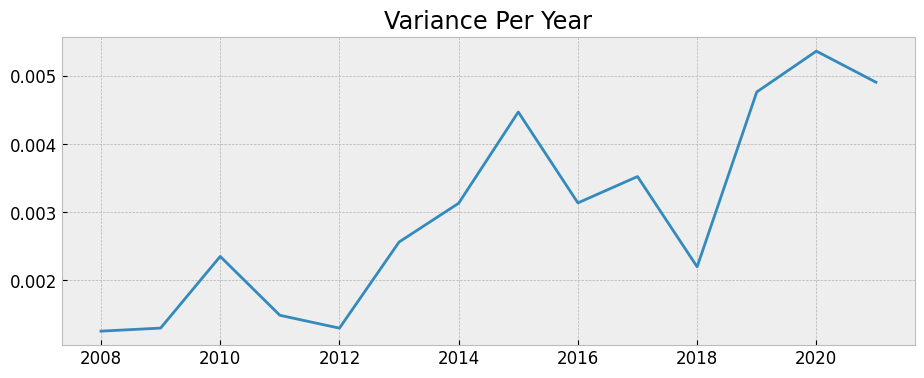

In [35]:
ts_train_log.groupby(ts_train_log.index.year).var().plot()
plt.title("Variance Per Year")

### ARIMA models
Let us now try forecasting using ARIMA models. <br>
The requirement for using an ARIMA model is that the time series must be stationary. A stationary time series is a series that has:
  * constant mean over time
  * constant variance over time
  * no seasonality
  
We can test whether a time series is stationary through a test known as the KPSS test, which we will use in this notebook.


In [41]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss


def test_stationarity(ts, lags=None):
    fig = plt.figure(figsize=(12, 5))
    
    fig.add_subplot(211)
    plt.plot(ts[12:])
    plt.title("Series")
    
    fig.add_subplot(223)
    plot_acf(ts, lags=40, ax=plt.gca())
    
    fig.add_subplot(224)
    plot_pacf(ts, method="ywm", lags=40, ax=plt.gca())
    
    
    plt.tight_layout()
    
    kpss_res = kpss(ts)
    print("KPSS P_value: ", kpss_res[1])
    

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


KPSS P_value:  0.01


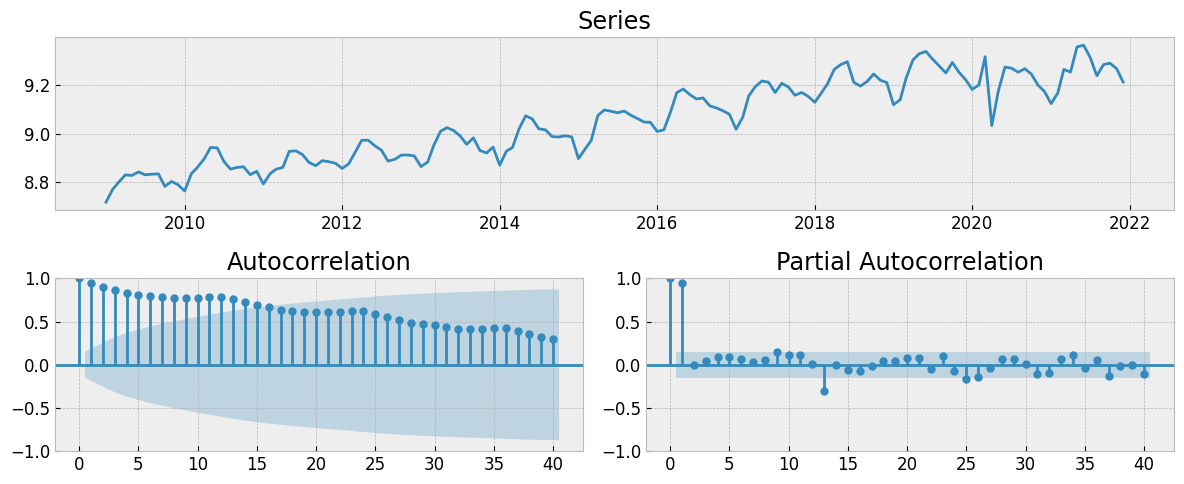

In [42]:
test_stationarity(ts_train_log)

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS P_value:  0.1


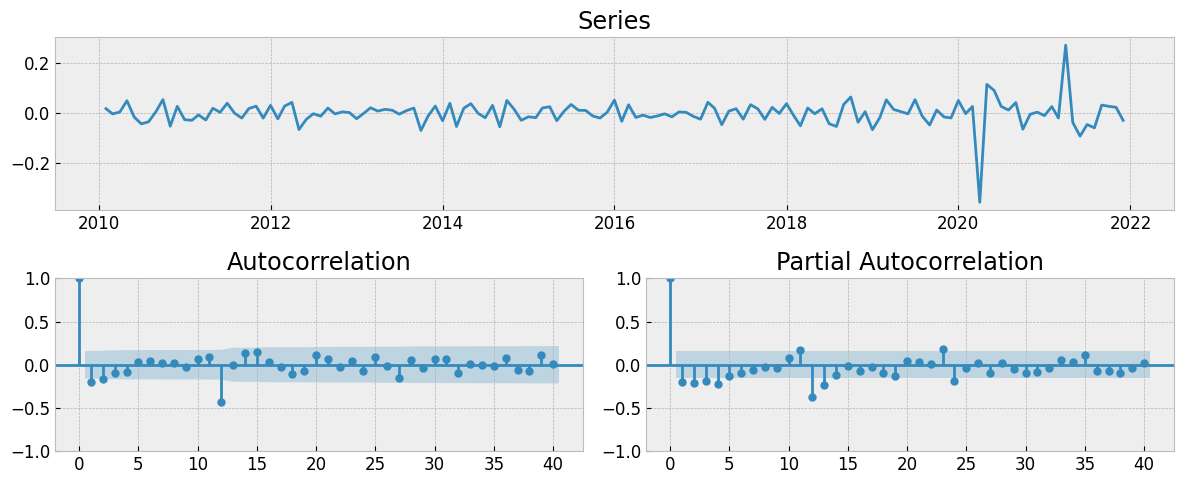

In [106]:
from statsmodels.tsa.statespace.tools import diff

diff_1_1 = diff(ts_train_log, k_diff=1, k_seasonal_diff=1, seasonal_periods=12)

test_stationarity(diff_1_1)

After one regular first order differencing and one seasonal differencing, we see in the top graph that the time series looks fairly stationary. <br>
The KPSS test returns a P-value of greater than 0.1, indicating that we have a stationary series after the differencing. <br>
The ACF plot suggests an MA(2) model and a seasonal MA(1) <br>
The PACF plot suggests an AR(4) model and a seasonal AR(1) or AR(2) model

In [44]:
from statsmodels.tsa.arima.model import ARIMA

def make_arima(y, p=0, d=0, q=0, P=0, D=0, Q=0, S=12, print_res=True):
    model = ARIMA(y, order=(p,d,q), seasonal_order=(P,D,Q,S))
    res = model.fit()
    if print_res:
        print(res.summary())
    return res 


In [45]:
arima_410_110 = make_arima(ts_train_log, p=4, d=1, P=1, D=1)
print("############################################################################################")
arima_410_210 = make_arima(ts_train_log, p=4, d=1, P=2, D=1)
print("############################################################################################")
arima_012_011 = make_arima(ts_train_log, q=2, d=1, Q=1, D=1)

                                    SARIMAX Results                                     
Dep. Variable:                          mw_peak   No. Observations:                  168
Model:             ARIMA(4, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 286.017
Date:                          Wed, 09 Aug 2023   AIC                           -560.034
Time:                                  14:43:30   BIC                           -541.774
Sample:                              01-01-2008   HQIC                          -552.617
                                   - 12-01-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4081      0.133     -3.077      0.002      -0.668      -0.148
ar.L2         -0.3226      0.099     -3.251      0.

**from our results the model with the lowest AIC is the ARIMA(0,1,2)(0,1,1)12 model**

3.4565391295833185


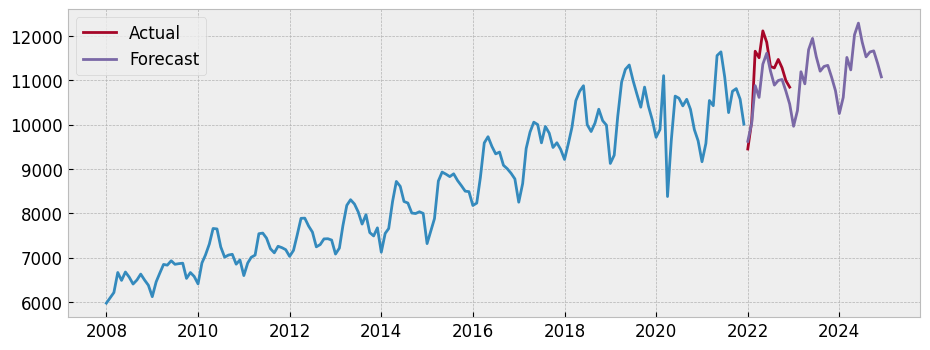

In [49]:
def mape_score(y, y_pred, transform=True):
    if transform:
        return mape(np.e ** y, np.e ** y_pred) * 100
    return mape(y, y_pred) * 100

arima012011_preds = arima_012_011.forecast(36)
plot_fore(ts_train_log, ts_test_log, arima012011_preds, True)

print(mape_score(ts_test_log, arima012011_preds[:12]))

We have a mape of around 3.46% on the test set, but we clearly see in the plot that the model is underforecasting for the year 2022. This is due to the effect of the pandemic, which caused a level and probably a trend change in the series.

In [131]:
from  pmdarima.arima import AutoARIMA

auto_arima = AutoARIMA(m=12)
auto_arima.fit(ts_train_log)

print(auto_arima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 320.196
Date:                            Sun, 06 Aug 2023   AIC                           -628.392
Time:                                    21:54:40   BIC                           -609.684
Sample:                                01-01-2008   HQIC                          -620.798
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.806e-05      0.000      0.672      0.502      -0.000       0.000
ar.L1          0.4529      0.156   

The best model found by the autoARIMA algorithm is an ARIMA(1,1,1)(1,0,1)12 model. Though we cannot compare the AIC of this model to the previous three that we've tried since they have different order of differencing.

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


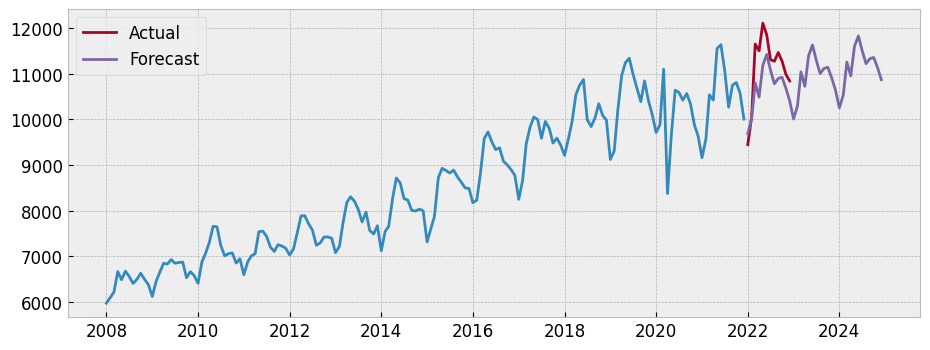

In [50]:
arima_111_101 = make_arima(y=ts_train_log, p=1, d=1, q=1, P=1, Q=1, print_res=False)
arima_111_101_fore = arima_111_101.forecast(36)

plot_fore(ts_train_log, ts_test_log, arima_111_101_fore, True)

The predictions of the model found by the automated algorithms look worse than the predictions made by our manually crafted models.

## Exogenous regressors

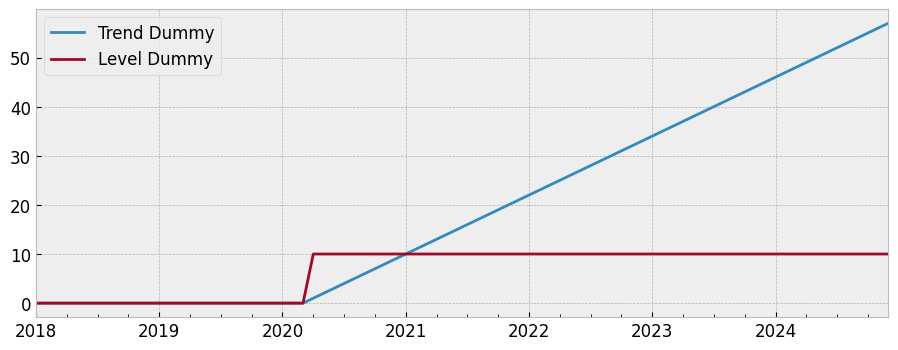

In [58]:
dates_2 = pd.date_range(start="2008-01-01", end="2024-12-01", freq="MS")
dates_with_trend = pd.date_range(start="2020-03-01", end="2024-12-01", freq="MS")

trend_change = pd.Series(np.zeros(len(dates_2)), index=dates_2)
trend_change[trend_change.index >= "2020-03-01"] = np.arange(len(dates_with_trend))

trend_change[trend_change.index.year >= 2018].plot(label="Trend Dummy")

level_change = trend_change.copy()
level_change[level_change.index > "2020-03-01"] = 1
#Multiply it by 10 just for plotting

(level_change[level_change.index.year >= 2018] * 10).plot(label="Level Dummy")
plt.legend()



We'll use a trend and level dummy variable that only activates after the start of the pandemic in order to offset its effects on the time series.

In [59]:
df_exog = pd.DataFrame([trend_change, level_change]).T
df_exog.columns = ["Trend Dummy", "Level Dummy"]

exog_train = df_exog[df_exog.index.year < 2022]
exog_test = df_exog[df_exog.index.year == 2022]
exog_fore = df_exog[df_exog.index.year >= 2022]

                                     SARIMAX Results                                      
Dep. Variable:                            mw_peak   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 356.553
Date:                            Wed, 09 Aug 2023   AIC                           -699.106
Time:                                    14:57:19   BIC                           -677.280
Sample:                                01-01-2008   HQIC                          -690.247
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Trend Dummy     0.0079      0.004      2.256      0.024       0.001       0.015
Level Dummy    -0.2858      0.01

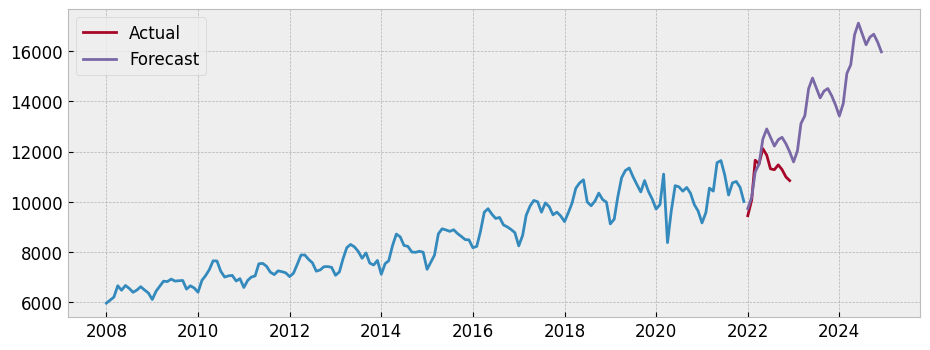

In [60]:
# Let's fit an ARIMA(1,1,1)(1,0,1)12 

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(ts_train_log,
                 exog=exog_train,
                 order=(1,1,1),
                 seasonal_order=(1,0,1,12),
                 )

sarimax_model = sarimax.fit(maxiter=200)

print(sarimax_model.summary())
sarimax_fore = sarimax_model.forecast(36, exog=exog_fore)
plot_fore(ts_train_log, ts_test_log, sarimax_fore, True)

The effect is disastrous on the forecast, the model is now severly over-forecasting the trend. This is probably due to the combined effect of the differencing and the trend exogenous variable. Let's try to exclude the trend variable and refit the model.

                                     SARIMAX Results                                      
Dep. Variable:                            mw_peak   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 354.372
Date:                            Wed, 09 Aug 2023   AIC                           -696.744
Time:                                    14:57:30   BIC                           -678.036
Sample:                                01-01-2008   HQIC                          -689.150
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Level Dummy    -0.2817      0.015    -19.021      0.000      -0.311      -0.253
ar.L1           0.7722      0.10

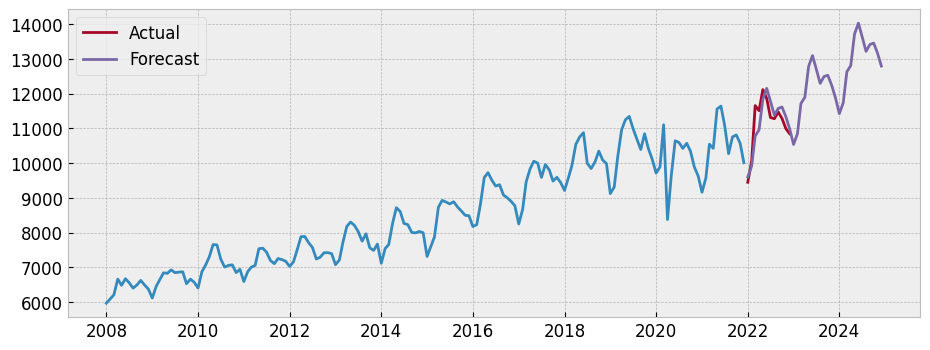

In [61]:
exog_train2 = exog_train["Level Dummy"]
exog_fore2 = exog_fore["Level Dummy"]

sarimax2 = SARIMAX(ts_train_log,
                 exog=exog_train2,
                 order=(1,1,1),
                 seasonal_order=(1,0,1,12),
                 )

sarimax_model2 = sarimax2.fit(maxiter=200)

print(sarimax_model2.summary())
sarimax_fore2 = sarimax_model2.forecast(36, exog=exog_fore2)
plot_fore(ts_train_log, ts_test_log, sarimax_fore2, True)

So we only needed the level trend variable in order to negate the effects of the pandemic.

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS P_value:  0.1


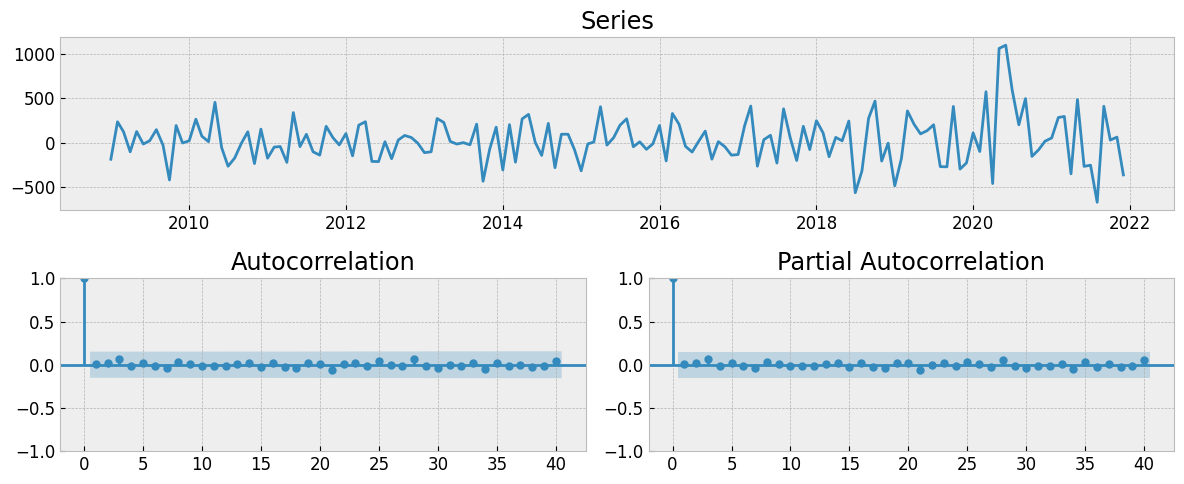

In [92]:
smx2_preds = sarimax_model2.predict()
res = np.e**ts_train_log - np.e**smx2_preds

test_stationarity(res)

The residuals looks good and the kpss test returns not significant, which means that the residuals are stationary.

In [63]:
#fit the whole dataset and produce 3 year forecast

ts_log = np.log(ts)
time_horizon = 3
exog_ = pd.DataFrame(np.zeros(len(ts) + time_horizon * 12))
exog_.index = pd.date_range(start="2008-01-01", freq="MS", periods=(len(ts) + time_horizon * 12))
exog_.columns = ["pandemic_shock"]

exog_[exog_.index >= "2020-03-01"] = 1
exog_train = exog_[exog_.index.year <= 2022]
exog_test = exog_[exog_.index.year > 2022]




In [64]:
final_model = SARIMAX(ts_log,
                     exog=exog_train,
                     order=(1,1,1),
                     seasonal_order=(1,0,1,12)).fit(maxiter=200)
final_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            mw_peak   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 349.582
Date:                            Wed, 09 Aug 2023   AIC                           -687.164
Time:                                    14:58:53   BIC                           -668.039
Sample:                                01-01-2008   HQIC                          -679.409
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
pandemic_shock    -0.0888      0.008    -11.533      0.000      -0.104      -0.074
ar.L1              0.2657      0.114      2.329      0.020       0.042       0.489
ma.L1             -0.8884      0.059    -15.072      0.000      -1.004      -0.773
ar.S.L12           0.9793      0.019     50.222      0.000       0.941       1.018
ma.S.L12          -0.7106      0.095     -7.510      0.000      -0.896      -0.525
sigma2             0.0011   8.65e-05     12.241      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              5262.99
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               4.45   Skew:                            -2.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\jamael\Documents\HandsOnML\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS P_value:  0.1


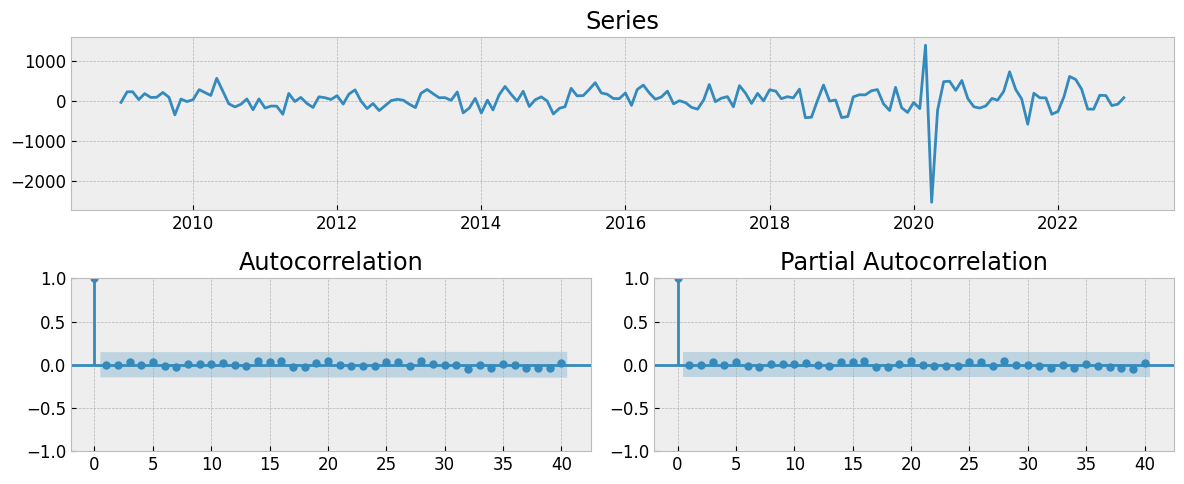

In [65]:
final_model_preds = np.e ** final_model.predict()
resids  =  ts - final_model_preds

test_stationarity(resids)

The residuals looks fairly good and the KPSS test results agree with our conclusion.

## Results

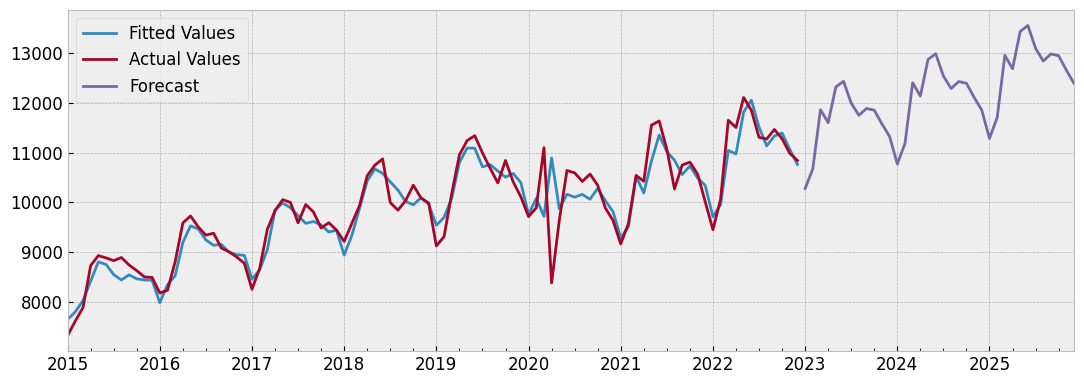

In [66]:
forecast = np.e**final_model.forecast(36, exog=exog_test)
final_model_preds[final_model_preds.index.year >= 2015].plot(label="Fitted Values")
ts[ts.index.year >= 2015].plot(label="Actual Values")
forecast.plot(label="Forecast")

plt.legend()
plt.tight_layout()

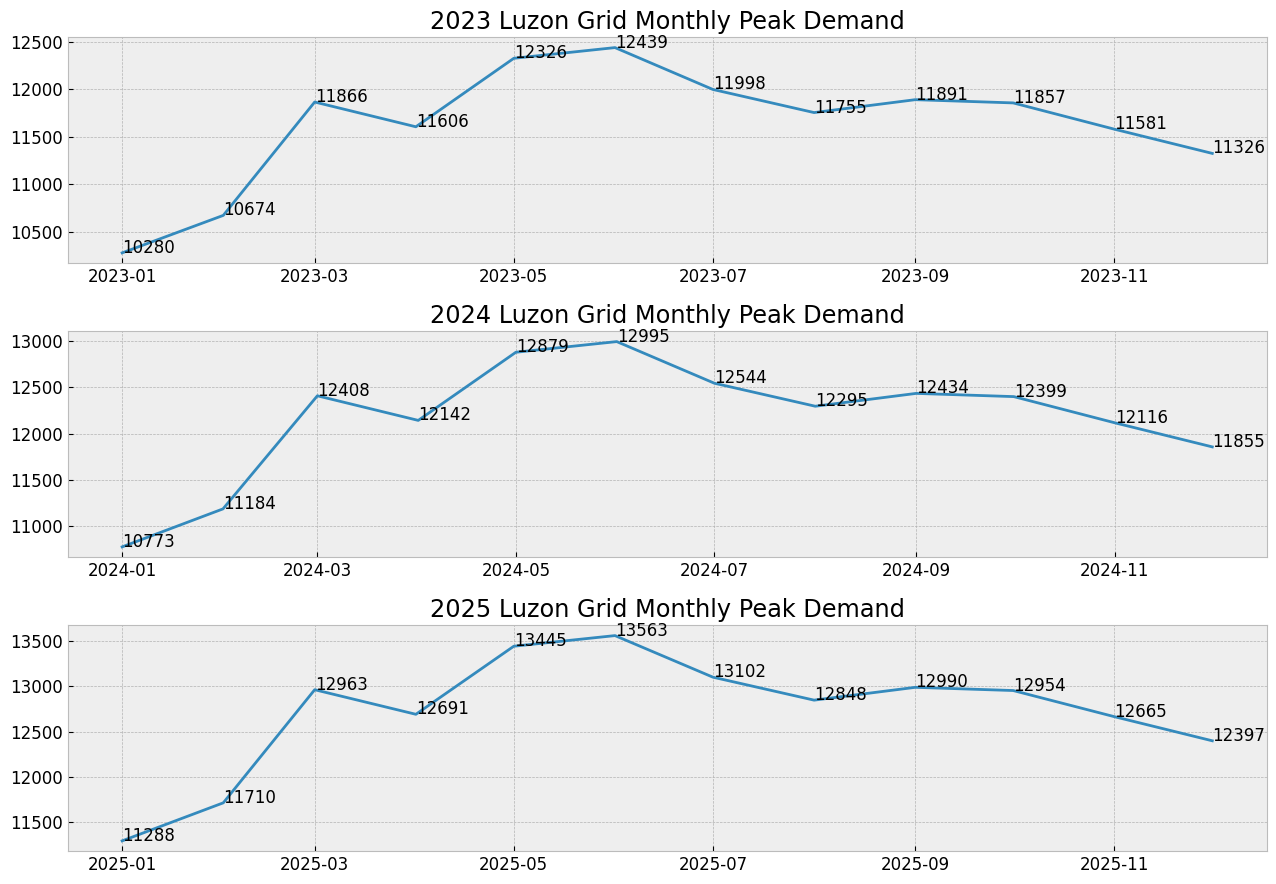

In [107]:

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(13, 9))

for year in range(2023, 2026):
    
    forecast_ = forecast[forecast.index.year == year]
    ax_ = ax[year - 2023]
    ax_.plot(forecast_)
    ax_.set_title("{} Luzon Grid Monthly Peak Demand".format(year))
    
    for i, val in enumerate(forecast_):
        ax_.annotate(int(val), (forecast_.index[i], forecast_[i]))
        
plt.tight_layout()   

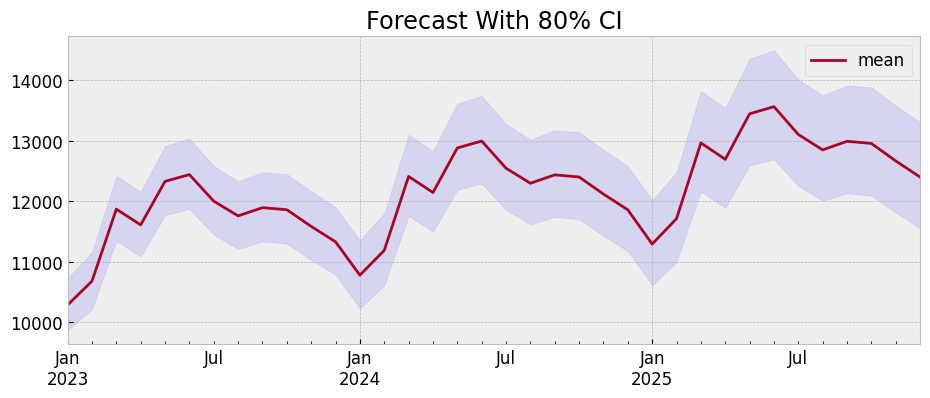

In [70]:
summary_frame = np.e ** final_model.get_forecast(36, exog=exog_test).summary_frame(alpha=0.2)
summary_frame[["mean"]].plot(color="C1", label="Luzon Electrical Demand Forecast")
ax2 = plt.gca()
ax2.fill_between(summary_frame.index, summary_frame.mean_ci_lower, summary_frame.mean_ci_upper, color="blue", alpha=0.1)
ax2.set_title("Forecast With 80% CI")
plt.legend()